<a href="https://colab.research.google.com/github/chasubeen/ESAA_8th_OB/blob/Week_5/%EB%B9%84%EC%A7%80%EB%8F%84%ED%95%99%EC%8A%B5_%EC%97%B0%EC%8A%B5%EB%AC%B8%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **| 비지도 학습 연습 문제**
___
- 출처 : 핸즈온 머신러닝 Ch09 앙상블 학습과 랜덤 포레스트 연습문제 3, 5, 8, 10번
- 이론적 지식을 묻는 문제의 경우 텍스트 셀을 추가하여 정답을 적어주세요.

In [1]:
# import libraries
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### **1. k-평균을 사용할 때 적절한 클러스터 개수를 선택할 수 있는 두 가지 기법을 설명하세요.**
___



1) Elbow method
- 각 클러스터 개수에 따른 inertia plot을 그리고 그래프에서 inertia의 감소 속도가 급격하게 감소하는 지점을 탐색
  - 일반적으로 해당 지점이 최적의 클러스터일 확률이 높음  

2) 실루엣 계수(점수) 확인
  - -1에서 1 사이
  - 1에 가까울수록 good
  - 각 클러스터 별로 실루엣 계수가 비슷할수록 good

### **2. 대규모 데이터셋으로 확장할 수 있는 군집 알고리즘 두 개를 말해보세요. 밀도가 높은 지역을 찾는 군집 알고리즘 두 개는 무엇인가요?**
___


- 대규모 데이터셋으로 확장할 수 있는 군집 알고리즘
  - KMeans
  - BIRCH
- 밀도가 높은 지역을 찾는 군집 알고리즘
  - DBSCAN
  - Mean Shift

### **3. 가우시안 혼합이 무엇인가요? 어떤 작업에 사용할 수 있나요?**
___


- 샘플이 파라미터를 모르는 몇 개의 가우시안 분포를 기반으로 생성되었다고 가정하는 확률 모델
  - 데이터가 유한한 개수의 타원 모양 클러스터로 그룹지어 있다고 가정
  - 그러나 샘플이 어떤 클러스터에 속하는지는 알 수 없음
- 활용
  - 밀집도 추정, 이상치 탐지 등에 활용할 수 있음

### **4. 다음 단계를 따라 올리베티 얼굴 데이터셋을 군집해보자..**
___
전통적인 올리베티 얼굴 데이터셋은 64 X 64 픽셀 크기의 흑백 얼굴 이미지 400개를 가지고 있습니다. 사람 40명의 사진을 10장씩 찍은 것인데, 각 이미지는 4096 크기의 1D 벡터로 펼쳐져 있습니다.

#### **STEP 1. 아래 코드를 실행하여 데이터셋을 불러오세요.**

In [2]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


####  **STEP 2. 데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 나누세요.**
해당 데이터셋은 매우 작으므로, `StratifiedShuffleSplit` 함수를 이용하여, 계층적 샘플링으로 각 세트에 동일한 사람의 얼굴이 고루 섞이도록 하세요.

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

## 훈련 데이터 vs 테스트 데이터
strat_split = StratifiedShuffleSplit(n_splits = 1, test_size = 40, random_state = 42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

## 훈련 데이터 vs 검증 데이터
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [4]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


####  **STEP 3. 속도를 높이기 위해 각 학습/검증/테스트 피처 데이터셋에 PCA을 적용하여 데이터의 차원을 줄이세요.**
- `n_componets = 0.99`로 설정합니다.

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.99)

X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

- 4096개의 속성이 199개의 속성으로 축소됨

####  **STEP 4. 교재에서 다룬 방법을 사용하여 적절한 클러스터 개수를 찾고 k-평균을 사용해 이미지를 군집해보세요.**

**1) 실루엣 계수**

In [10]:
## 여러 군집 개수 시도해보기

from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
  kmeans = KMeans(n_clusters = k, n_init = 'auto', random_state = 42).fit(X_train_pca)
  kmeans_per_k.append(kmeans)

In [11]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_) for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

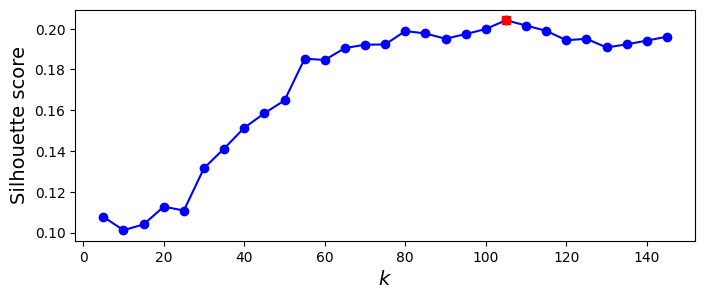

In [12]:
## 시각화

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [13]:
best_k

105

- 군집 개수는 **105개**가 가장 적절해 보임
  - 하지만, 여전히 큰 숫자

**2) inertia 활용**

In [14]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

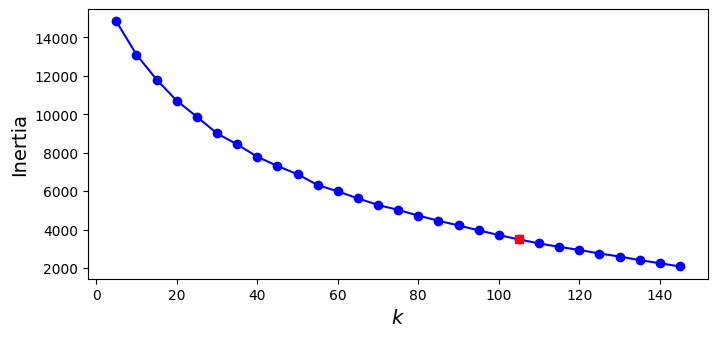

In [15]:
## 시각화

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

- 이너셔 그래프에서는 엘보우 지점이 없기 때문에 최적의 클러스터 개수가 명확하지 않음
> k = 105을 활용

In [16]:
best_model = kmeans_per_k[best_index]

####  **STEP 5. 아래 `plot_faces` 함수를 이용하여, 클러스터를 시각화하고, 각 클러스터에 비슷한 얼굴이 들어있는지 확인해보세요.**

In [17]:
# plot_faces 함수
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

Cluster 0


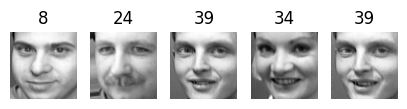

Cluster 1


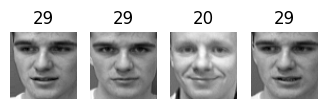

Cluster 2


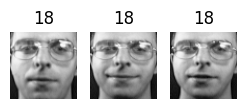

Cluster 3


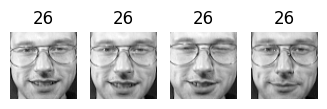

Cluster 4


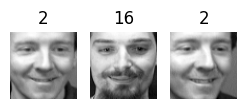

Cluster 5


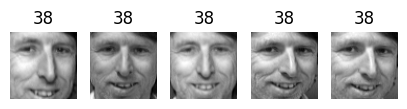

Cluster 6


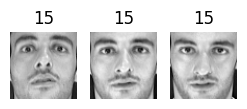

Cluster 7


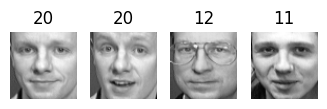

Cluster 8


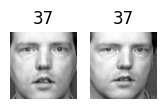

Cluster 9


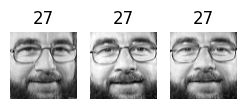

Cluster 10


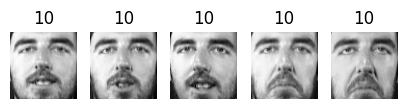

Cluster 11


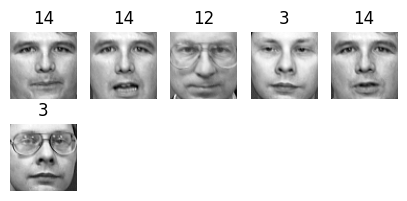

Cluster 12


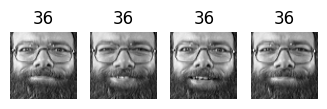

Cluster 13


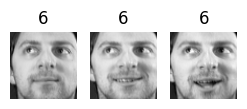

Cluster 14


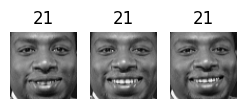

Cluster 15


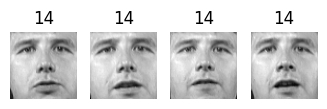

Cluster 16


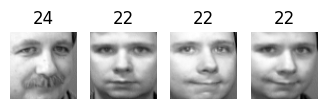

Cluster 17


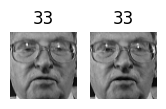

Cluster 18


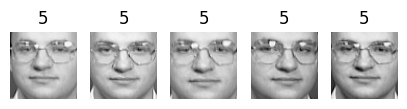

Cluster 19


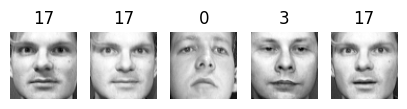

Cluster 20


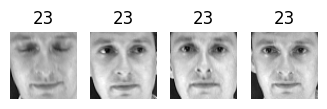

Cluster 21


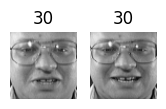

Cluster 22


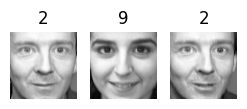

Cluster 23


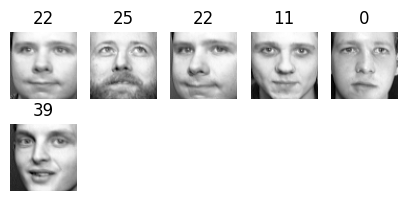

Cluster 24


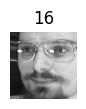

Cluster 25


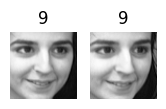

Cluster 26


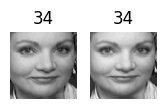

Cluster 27


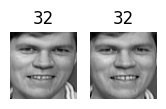

Cluster 28


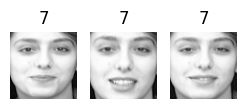

Cluster 29


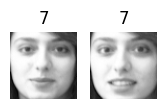

Cluster 30


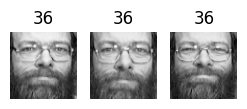

Cluster 31


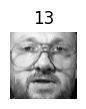

Cluster 32


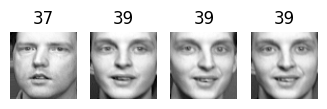

Cluster 33


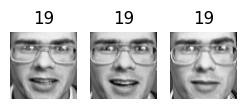

Cluster 34


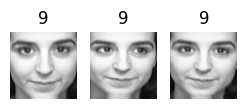

Cluster 35


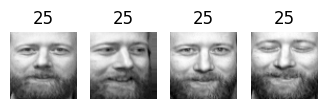

Cluster 36


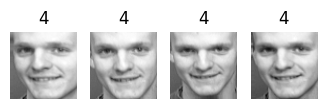

Cluster 37


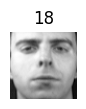

Cluster 38


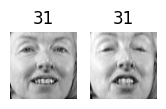

Cluster 39


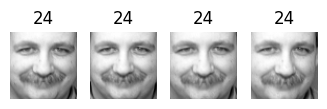

Cluster 40


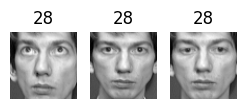

Cluster 41


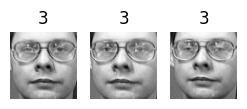

Cluster 42


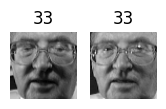

Cluster 43


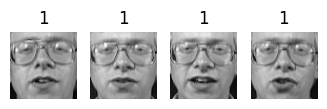

Cluster 44


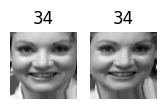

Cluster 45


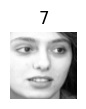

Cluster 46


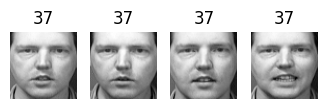

Cluster 47


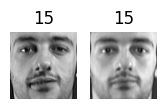

Cluster 48


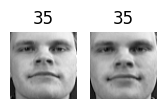

Cluster 49


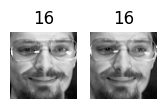

Cluster 50


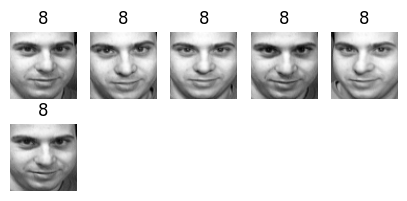

Cluster 51


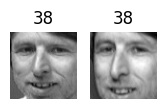

Cluster 52


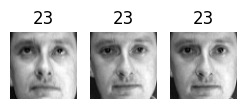

Cluster 53


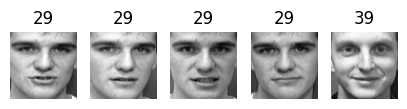

Cluster 54


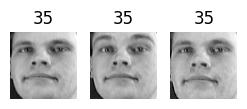

Cluster 55


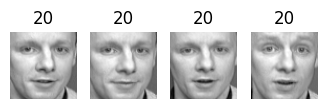

Cluster 56


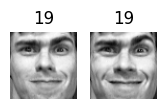

Cluster 57


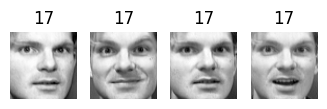

Cluster 58


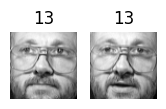

Cluster 59


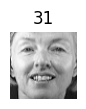

Cluster 60


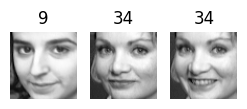

Cluster 61


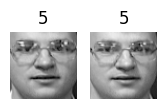

Cluster 62


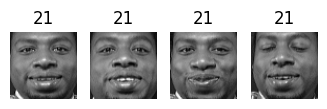

Cluster 63


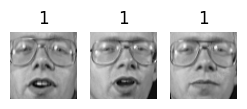

Cluster 64


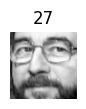

Cluster 65


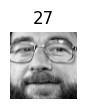

Cluster 66


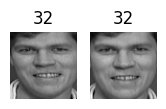

Cluster 67


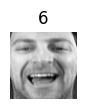

Cluster 68


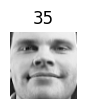

Cluster 69


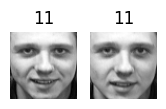

Cluster 70


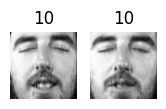

Cluster 71


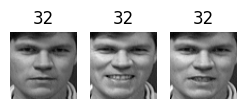

Cluster 72


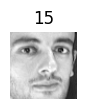

Cluster 73


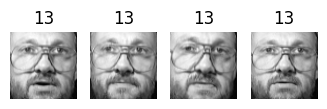

Cluster 74


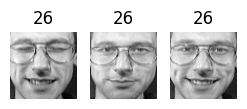

Cluster 75


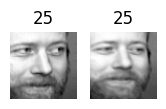

Cluster 76


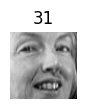

Cluster 77


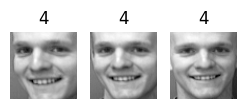

Cluster 78


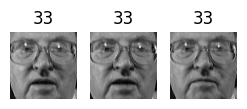

Cluster 79


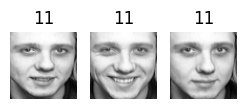

Cluster 80


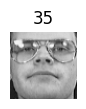

Cluster 81


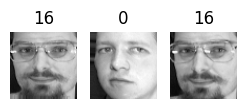

Cluster 82


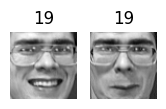

Cluster 83


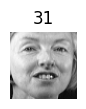

Cluster 84


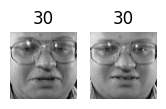

Cluster 85


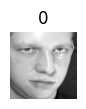

Cluster 86


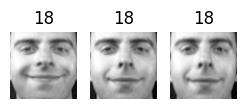

Cluster 87


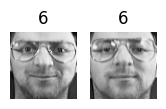

Cluster 88


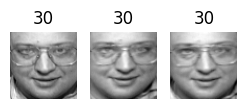

Cluster 89


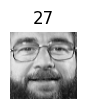

Cluster 90


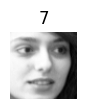

Cluster 91


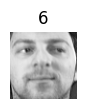

Cluster 92


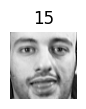

Cluster 93


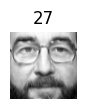

Cluster 94


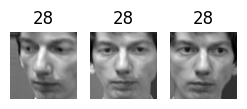

Cluster 95


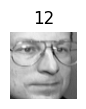

Cluster 96


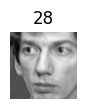

Cluster 97


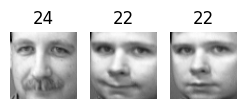

Cluster 98


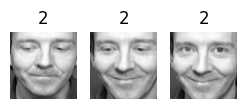

Cluster 99


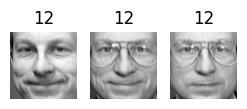

Cluster 100


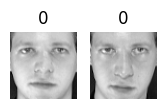

Cluster 101


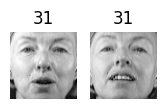

Cluster 102


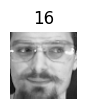

Cluster 103


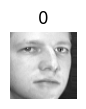

Cluster 104


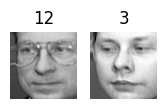

In [18]:
## 군집별로 사진 시각화

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

- 대체로 클러스터는 균일한 크기를 가지고 있음
  - 적어도 2개의 사진을 가지고 있고 모두 동일한 사람임
- 하지만 1/3 정도의 클러스터는 다른 사람 얼굴이 하나 이상 있거나 하나의 사진만 가지고 있음
> 너무 세분화된 것 같음  
(아마도 사진의 화질이나 사진이 찍힌 각도 또한 영향을 많이 받는 것으로 짐작됨)